# Class-Conditional Synthesis with Latent Diffusion Models

In [1]:
%load_ext autoreload
%autoreload 2

Install all the requirements

In [2]:
# #@title Installation
# !git clone https://github.com/CompVis/latent-diffusion.git
# !git clone https://github.com/CompVis/taming-transformers
# !pip install -e ./taming-transformers
# !pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
# from taming.models import vqgan 

In [3]:
! cd ../

In [10]:
import os
os.getcwd()

'/Users/danatal/projects/deep_learning/projectv2/PSLD/stable-diffusion/scripts'

Now, download the checkpoint (~1.7 GB). This will usually take 1-2 minutes.

In [2]:
#@title Download
%cd latent-diffusion/ 

!mkdir -p models/ldm/cin256-v2/
!wget -O models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt 

[Errno 2] No such file or directory: 'latent-diffusion/'
/Users/danatal/projects/deep_learning/projectv2/PSLD/stable-diffusion/scripts
--2025-08-12 16:10:12--  https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt
Resolving ommer-lab.com (ommer-lab.com)... 141.84.41.65
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
...הבושת תלבקל ןיתממ ,החלשנ HTTP תיינפ 200 OK
Length: 1827378153 (1.7G)
Saving to: ‘models/ldm/cin256-v2/model.ckpt’

models/ldm/cin256-v 100%[===================>]   1.70G  33.5MB/s    in 60s     

2025-08-12 16:11:15 (29.2 MB/s) - ‘models/ldm/cin256-v2/model.ckpt’ saved [1827378153/1827378153]



Let's also check what type of GPU we've got.

Load it.

In [4]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config

def _get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def load_model_from_config(config, ckpt, verbose=False):
    device = _get_device()
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.to(device)
    model.eval()
    return model

def get_model():
    config = OmegaConf.load("../configs/latent-diffusion/cin256-v2.yaml")  
    model = load_model_from_config(config, "./models/ldm/cin256-v2/model.ckpt")
    return model

In [5]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

Loading model from ./models/ldm/cin256-v2/model.ckpt


/Users/danatal/tools/miniconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


/Users/danatal/tools/miniconda3/envs/ldm/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

rendering 6 examples of class '25' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


rendering 6 examples of class '187' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


rendering 6 examples of class '448' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


rendering 6 examples of class '992' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


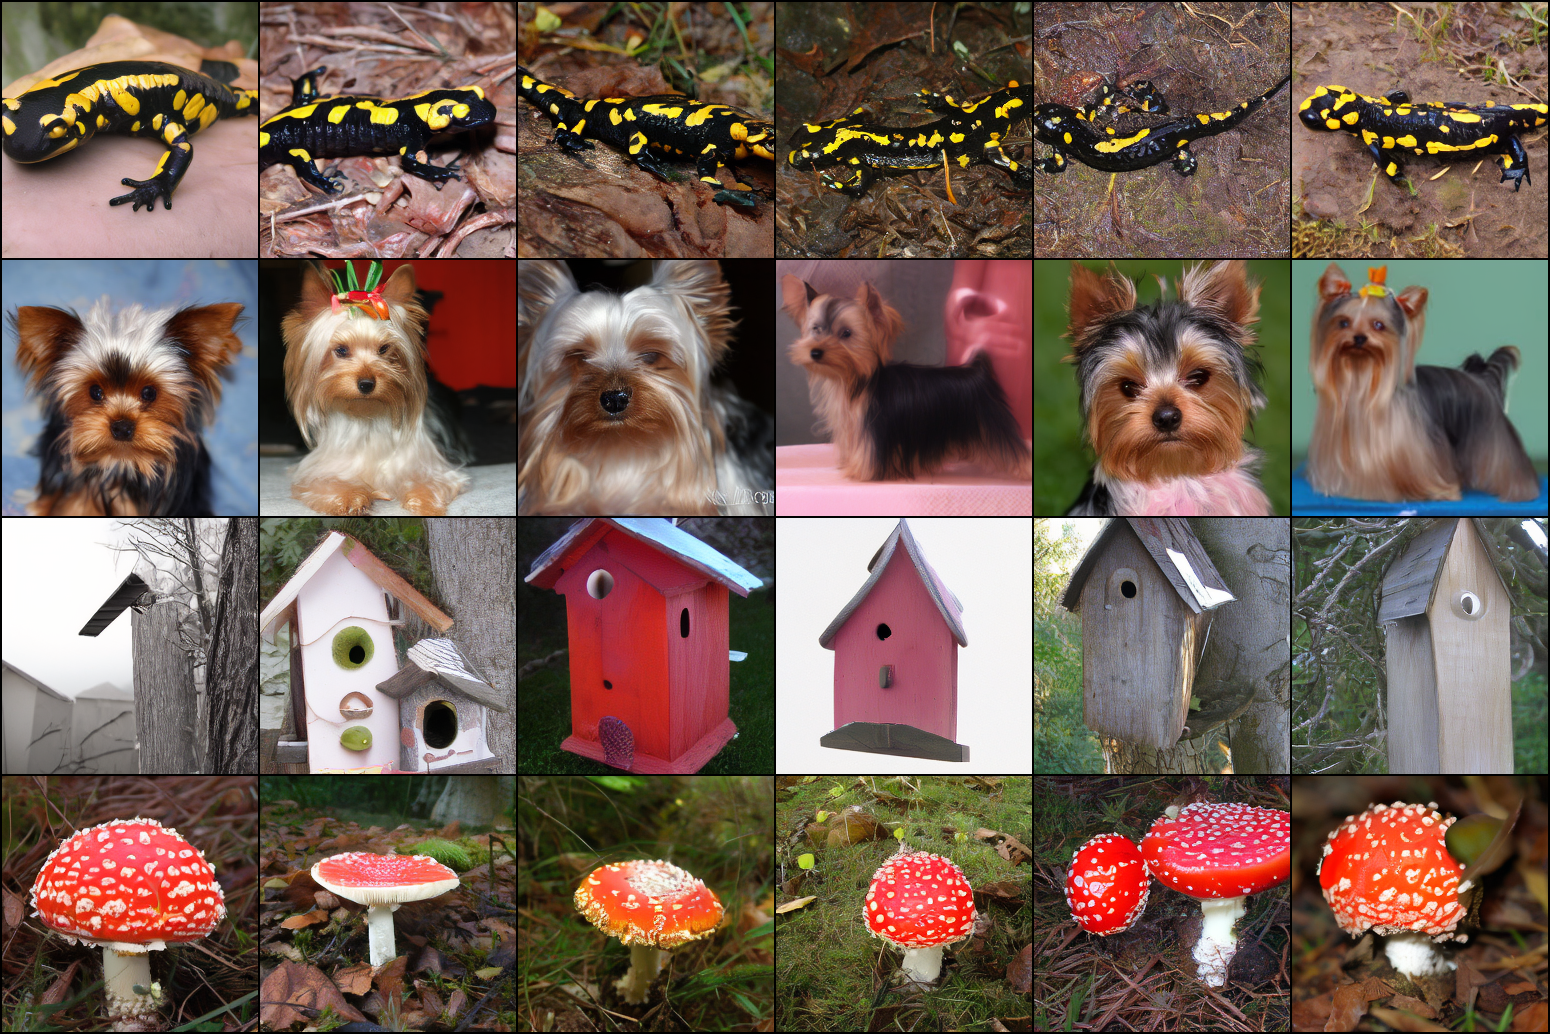

In [7]:
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid


classes = [25, 187, 448, 992]   # define classes to be sampled here
n_samples_per_class = 6

ddim_steps = 20
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)}
            )
        
        for class_label in classes:
            print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
            
            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_class,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc, 
                                             eta=ddim_eta,
                                             )

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

In [9]:
c.shape

torch.Size([6, 1, 512])

In [ ]:
n_samples_per_class

6

: 